<a href="https://colab.research.google.com/github/yeshurunlevi/popularity-of-restaurants-in-Greece/blob/main/popularity_of_restaurants_in_Greece.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

columns:

link - ID?

name - name

original_location - list of all

claimed - restaurant business claimed on TripAdvisor

awards - awards, when get.

popularity_detailed - popularity detailed ranking

popularity_generic - popularity generic ranking (among all places to eat in the area)

top_tags - top tag names (key words?)

price_level - level of prices in current currency (data scraped from www.tripadvisor.ie - so currency is €)

price_range - range of prices in current currency (ranges displayed on TripAdvisor seem to be quite unreliable)

meals - types of meal

cuisines - types of cuisine

special_diets - types of special diets

features - restaurant features

vegetarian_friendly - is the restaurant vegetarian friendly?

vegan_options - does the restaurant offer vegan options?

gluten_free - does the restaurant gluten-free options?

##edit_1

In [82]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder

df = pd.read_csv(r'/content/drive/MyDrive/Trip Advisor EU restaurants /tripadvisor_european_restaurants.csv')

<ipython-input-82-9216e2ab3be7>:6: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'/content/drive/MyDrive/Trip Advisor EU restaurants /tripadvisor_european_restaurants.csv')


In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1083397 entries, 0 to 1083396
Data columns (total 42 columns):
 #   Column                             Non-Null Count    Dtype  
---  ------                             --------------    -----  
 0   restaurant_link                    1083397 non-null  object 
 1   restaurant_name                    1083396 non-null  object 
 2   original_location                  1083397 non-null  object 
 3   country                            1083397 non-null  object 
 4   region                             1033074 non-null  object 
 5   province                           742765 non-null   object 
 6   city                               682712 non-null   object 
 7   address                            1083397 non-null  object 
 8   latitude                           1067607 non-null  float64
 9   longitude                          1067607 non-null  float64
 10  claimed                            1081555 non-null  object 
 11  awards                  

In [84]:
df2 = df.copy()
df2 = df2[(df['total_reviews_count'] >= 10) & (df['country'] == 'Greece')]

#df2 = df2.applymap(lambda x: x.replace(" ", "") if isinstance(x, str) else x)
df2 = df2.applymap(lambda x: x.lower() if isinstance(x, str) else x)


def succ(x):
  if x >= 4.5:
    return 1
  else:
    return 0
df2['success (target)'] = [succ(x) for x in df2['avg_rating']]

<ipython-input-84-f49f0068eb8d>:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df2 = df2.applymap(lambda x: x.lower() if isinstance(x, str) else x)


In [85]:
df2['success (target)'].value_counts()

,count
success (target),
1,13796
0,8194


In [86]:
# Extract only the ranking number, handling NaNs
df2["popularity_detailed"], df2["restaurants"] = df["popularity_detailed"].str.extract(r'#(\d)'), df["popularity_detailed"].str.extract(r'#(\d+)')
df2["popularity_generic"], df2["places"] = df["popularity_generic"].str.extract(r'#(\d)'), df["popularity_generic"].str.extract(r'#(\d+)')

df2["popularity_detailed"], df2["restaurants"], df2["popularity_generic"], df2["places"] = df2["popularity_detailed"].astype(float), df2["restaurants"].astype(float), df2["popularity_generic"].astype(float), df2["places"].astype(float)

In [87]:

df2['price_level'] = df['price_level'].map({'€': 1, '€€-€€€': 2, '€€€€': 3})
df2['claimed'] = df['claimed'].map({'Claimed': 1, 'Unclaimed': 0})
df2['default_language'] = df['default_language'].map({'English': 0, 'All languages': 1})

In [88]:

import ast

# Function to process opening hours safely
def process_opening_hours(opening_hours):
    if not isinstance(opening_hours, str) or not opening_hours.strip():
        return [None, None, None, None, None, None]  # Handles None, NaN, or empty string

    try:
        hours_dict = ast.literal_eval(opening_hours)
        if not isinstance(hours_dict, dict):
            return [0, 0, 0, 0, 0, 0]

        total_days_open = 0
        total_hours = 0
        morning, noon, evening, night = 0, 0, 0, 0

        for day, periods in hours_dict.items():
            if periods:
                total_days_open += 1
                daily_hours = 0
                full_day_flag = False

                for period in periods:
                    start, end = period.split('-')
                    start_hour, start_minute = map(int, start.split(':'))
                    end_hour, end_minute = map(int, end.split(':'))

                    # Convert to float hours
                    start_time = start_hour + start_minute / 60
                    end_time = end_hour + end_minute / 60

                    # Handle cases where closing time is past midnight
                    if end_time < start_time:
                        end_time += 24

                    hours_open = end_time - start_time
                    daily_hours += hours_open

                    # Check time slots
                    if start_time < 6:
                        night = 1
                    if start_time < 12 and end_time > 6:
                        morning = 1
                    if start_time < 18 and end_time > 12:
                        noon = 1
                    if start_time < 24 and end_time > 18:
                        evening = 1
                    if hours_open >= 12:
                        full_day_flag = True

                total_hours += daily_hours

        avg_hours_per_day = total_hours / total_days_open if total_days_open else 0
        return [total_days_open, round(avg_hours_per_day, 1), morning, noon, evening, night]


    except (SyntaxError, ValueError, AttributeError, TypeError):
        return [0, 0, 0, 0, 0, 0]  # Safe fallback if parsing fails

# Apply function safely
df2[['open_days', 'avg_hours_per_day', 'morning', 'noon', 'evening', 'night']] = df2['original_open_hours'].apply(process_opening_hours).apply(pd.Series)




In [89]:
import statistics
def extract_prices(price_range):
    if pd.isna(price_range):
        return np.nan, np.nan  # Keep NaN for missing values
    else:
      prices = price_range.replace("€", "").replace(",", "").split("-")  # Remove € and split
    return [int(prices[0]), int(prices[1])]  # Convert to integers

# Apply function and create new columns
df2["min_price"] =[extract_prices(cell)[0] for cell in df2["price_range"]]
df2["max_price"] =[extract_prices(cell)[1] for cell in df2["price_range"]]

In [90]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21990 entries, 952974 to 986735
Data columns (total 53 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   restaurant_link                    21990 non-null  object 
 1   restaurant_name                    21990 non-null  object 
 2   original_location                  21990 non-null  object 
 3   country                            21990 non-null  object 
 4   region                             21990 non-null  object 
 5   province                           18520 non-null  object 
 6   city                               21987 non-null  object 
 7   address                            21990 non-null  object 
 8   latitude                           21340 non-null  float64
 9   longitude                          21340 non-null  float64
 10  claimed                            21983 non-null  float64
 11  awards                             10731 non-null  ob

In [91]:
import re

df2['awards'].fillna(' ', inplace=True)  # Replace NaN

# Apply function and expand into new columns
df2['michelin'] = [len(re.findall(r"michelin", cell, re.IGNORECASE)) for cell in df2['awards']]
df2['another'] = [len(re.findall(r"worth", cell, re.IGNORECASE)) + len(re.findall(r"good", cell, re.IGNORECASE)) for cell in df2['awards']]

<ipython-input-91-b760b950f3ec>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['awards'].fillna(' ', inplace=True)  # Replace NaN


In [92]:
# Function to clean and split addresses
def clean_and_split_address(address):
    address = address.lower().replace("greece", "").strip()  # Remove "Greece"

    # Ensure we have at least a street and city/zip
    parts = address.split(",", 1) if "," in address else [address, ""]

    street_info = parts[0].strip()  # Street + number
    city_zip = parts[1].strip() if len(parts) > 1 else ""  # City + ZIP if available

    # Extract ZIP code and city
    zip_code = []
    city = []
    for char in city_zip:
        if char.isdigit():
            zip_code.append(char)
        else:
            city.append(char)

    city = "".join(city).strip()
    zip_code = "".join(zip_code)

    # Extract Apartment Number and Street Name
    apartment_number = []
    street_name = []
    for char in street_info:
        if char.isdigit():
            apartment_number.append(char)
        else:
            street_name.append(char)

    street_name = "".join(street_name).strip()
    apartment_number = "".join(apartment_number)

    return pd.Series([apartment_number, street_name, city, zip_code])

# Apply function to DataFrame
df2[['Apartment Number', 'Street Name', 'City_2', 'Zip Code']] = df2['address'].apply(clean_and_split_address)


# Display results
df2[['Apartment Number', 'Street Name', 'City_2', 'Zip Code']]


,Apartment Number,Street Name,City_2,Zip Code
952974,13,sekeri,tolon,21056
952975,14,atkis st,tolon,21056
952976,59,sekeri,tolon,21056
952977,8,aktis,tolon,21056
952978,28,sekeri,tolon,21056
...,...,...,...,...
986731,,fodele,crete,71500
986732,,kalamaki,"chania town, crete",73100
986733,5,th km chania-kissamos old road,"kalamaki, chania town, crete",73500
986734,,peo kissamou chanion kalamaki beach,"kalamaki, chania town, crete",73100


In [93]:
import pandas as pd
from collections import Counter


# Function to split awards and count them
def count_awards(awards_column):
    # Split each entry in the column by commas and flatten the result
    all_awards = [award.strip() for entry in awards_column if type(entry) == str for award in entry.split(',')]

    # Use Counter to count occurrences of each award
    award_count = Counter(all_awards)

    return award_count


In [94]:
def extract_city(address):
    if isinstance(address, str):  # Check if the value is a string
        parts = address.split(",", 1)  # Split at the first comma
        return parts[0].strip()  # Return the part before the comma
    return ""  # Return an empty string if the address is not a string

# Fill NaN values in 'city' column with values from 'new city' column
df2['city'] = df2['city'].fillna(df2['City_2'].apply(extract_city))

In [95]:
df2['to_new_data'] = df2['top_tags'] + ',' +df2['meals']+ ',' + df2['cuisines'] + ',' + df2['special_diets']+ ',' + df2['features']+ ','+ df2['keywords']

import pandas as pd
from collections import Counter


# Function to split awards and count them
def count_awards(awards_column):
    # Split each entry in the column by commas and flatten the result
    all_awards = [award.strip() for entry in awards_column if type(entry) == str for award in entry.split(',')]

    # Use Counter to count occurrences of each award
    award_count = Counter(all_awards)

    return award_count

# Apply the function
top_counts = count_awards(df2['to_new_data'])


In [96]:
categories = {
    "seafood": ["sea", "fish", "sushi", "tuna"],
    "healthy": ["vegetarian", "gluten", "salad", "vegan", "organic", "fruit"],
    "fast_food": ["fast food", "burgers", "fries", "pizza"],
    "payment_cards": ["cards", "visa", "mastercard", "accepts", "accept", 'gift cards available', 'digital payments' ],
    "greek": ["greek"],
    "asian": ['asian','thai','vietnamese'],
    "parking": ["parking"],
    "mediterranean": ["mediterranean", "italy"],
    "seating": ['seating', 'highchairs available' 'table'],
   "drinks": ['alcohol' 'drinks', 'wine and beer', 'wine','bar', 'cocktail'],
    "accessible": ["wheelchair", "accessible"]
}

# Function to check if any keyword is present
def contains_keywords(text, keywords):
    if pd.isna(text):  # Handle NULL values
        return 0
    text = text.lower()
    return int(any(keyword in text for keyword in keywords))

# Create binary columns
for category, keywords in categories.items():
    df2[category] = df2["to_new_data"].apply(lambda x: contains_keywords(x, keywords))


In [97]:
#to drop
droping = ['restaurant_link', 'original_location','country', 'restaurant_link', 'awards', 'vegetarian_friendly', 'vegan_options', 'gluten_free', 'top_tags', 'meals'
, 'cuisines', 'special_diets', 'features', 'keywords', 'price_range', 'address', 'City_2', 'to_new_data', 'avg_rating'
 , 'original_open_hours', 'restaurant_name', 'excellent', 'very_good', 'average', 'poor','terrible', 'open_days', 'avg_hours_per_day']
df2 = df2.drop(columns=droping, axis=1)

In [98]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21990 entries, 952974 to 986735
Data columns (total 44 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   region                             21990 non-null  object 
 1   province                           18520 non-null  object 
 2   city                               21990 non-null  object 
 3   latitude                           21340 non-null  float64
 4   longitude                          21340 non-null  float64
 5   claimed                            21983 non-null  float64
 6   popularity_detailed                21986 non-null  float64
 7   popularity_generic                 21973 non-null  float64
 8   price_level                        21127 non-null  float64
 9   open_days_per_week                 12200 non-null  float64
 10  open_hours_per_week                12200 non-null  float64
 11  working_shifts_per_week            12200 non-null  fl

In [99]:
for col in df2.select_dtypes(include=['object']).columns:
    df2[col] = df2[col].astype('category')

# Convert categories to numeric codes for analysis
for col in df2.select_dtypes(include=['category']).columns:
    df2[col] = df2[col].cat.codes

In [100]:
df2.to_csv("/content/drive/MyDrive/Trip Advisor EU restaurants /tripadvisor_european_restaurants_1.csv")

##fill_null

In [2]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore, ks_2samp
from sklearn.preprocessing import LabelEncoder

df3 = pd.read_csv(r'/content/drive/MyDrive/Trip Advisor EU restaurants /tripadvisor_european_restaurants_1.csv', index_col=False)

In [3]:
int_cols = [col for col in df3.select_dtypes(include=['float']).columns if df3[col].dropna().mod(1).eq(0).all()]
df3[int_cols] = df3[int_cols].astype("Int64")
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21990 entries, 0 to 21989
Data columns (total 45 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         21990 non-null  int64  
 1   region                             21990 non-null  int64  
 2   province                           21990 non-null  int64  
 3   city                               21990 non-null  int64  
 4   latitude                           21340 non-null  float64
 5   longitude                          21340 non-null  float64
 6   claimed                            21983 non-null  Int64  
 7   popularity_detailed                21986 non-null  Int64  
 8   popularity_generic                 21973 non-null  Int64  
 9   price_level                        21127 non-null  Int64  
 10  open_days_per_week                 12200 non-null  Int64  
 11  open_hours_per_week                12200 non-null  flo

In [4]:
continuous_columns = ['latitude', 'longitude', 'open_hours_per_week', 'working_shifts_per_week', 'total_reviews_count', 'reviews_count_in_default_language',
                      'restaurants', 'places', 'open_days_per_week', 'min_price', 'max_price']
categorial_columns = [col for col in df3.columns if col not in  continuous_columns]
df_continuous = df3[continuous_columns]
whole_number_cols = [col for col in df3.columns if df3[col].dropna().mod(1).eq(0).all()]
df_cat = df3[categorial_columns]

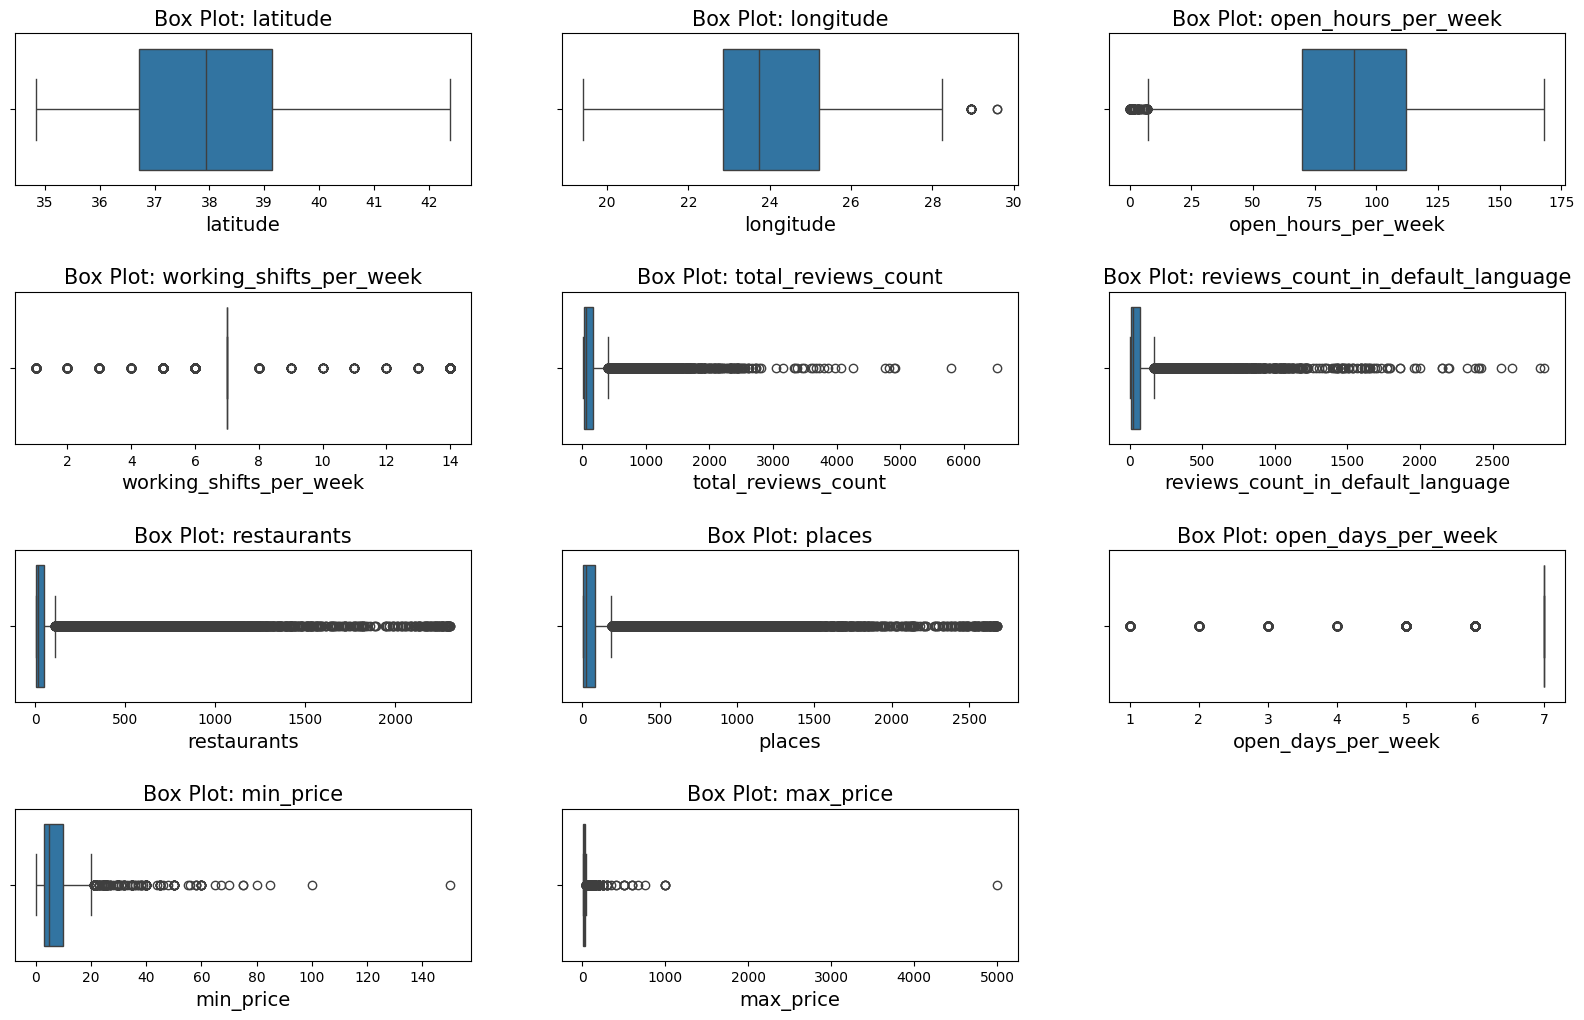

In [5]:
plt.figure(figsize=(20,200))

def outliers_boxplot(df):
    for i, col in enumerate(df.columns):
        if col != 'host_is_superhost':
            ax = plt.subplot(60, 3, i+1)
            sns.boxplot(data=df, x=col, ax=ax)
            plt.subplots_adjust(hspace = 0.7)
            plt.title('Box Plot: {}'.format(col), fontsize=15)
            plt.xlabel('{}'.format(col), fontsize=14)

outliers_boxplot(df3[continuous_columns])

In [6]:
from scipy.stats import ks_2samp  # Kolmogorov-Smirnov test for distribution check

def detect_outliers_iqr(df, threshold=1.5):
    """
    Detects outliers using the IQR method and returns a DataFrame summarizing them.
    """
    outliers_summary = []

    for col in df.select_dtypes(include=np.number):  # Only numeric columns
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_limit = Q1 - threshold * IQR
        upper_limit = Q3 + threshold * IQR

        outliers = df[(df[col] < lower_limit) | (df[col] > upper_limit)]
        num_outliers = len(outliers)

        outliers_summary.append({
            'Column': col,
            'Lower Limit': lower_limit,
            'Upper Limit': upper_limit,
            'Outlier Count': num_outliers,
            'Percent of Data': round(num_outliers / len(df) * 100, 2)
        })

    return pd.DataFrame(outliers_summary).sort_values(by='Outlier Count', ascending=False)

def analyze_capping_effect(df, outlier_info):
    """
    Checks if capping outliers changes distribution (KS-test) and correlation with other variables.
    """
    results = []

    for col in outlier_info['Column']:
        capped_df = df.copy()

        # Get IQR limits
        lower_limit = outlier_info[outlier_info['Column'] == col]['Lower Limit'].values[0]
        upper_limit = outlier_info[outlier_info['Column'] == col]['Upper Limit'].values[0]

        # Cap outliers
        capped_df[col] = np.clip(df[col], lower_limit, upper_limit)

        # Kolmogorov-Smirnov test for distribution change
        ks_stat, ks_p = ks_2samp(df[col].dropna(), capped_df[col].dropna())

        # Check correlation change
        original_corr = df.corr()[col].dropna()
        capped_corr = capped_df.corr()[col].dropna()
        corr_diff = (original_corr - capped_corr).abs().mean()

        results.append({
            'Column': col,
            'KS Statistic': ks_stat,
            'KS P-Value': ks_p,
            'Corr Change': corr_diff,
            'Lower Limit': lower_limit,
            'Upper Limit': upper_limit
        })

    return pd.DataFrame(results).sort_values(by='Corr Change', ascending=False)

def remove_unnecessary_outliers(df, outlier_info, ks_threshold=0.05, corr_threshold=0.05):
    """
    Removes outliers where capping does NOT significantly change distribution or correlation.
    """
    cols_to_remove_outliers = outlier_info[
        (outlier_info['KS P-Value'] > ks_threshold) &  # No significant distribution change
        (outlier_info['Corr Change'] < corr_threshold)  # No significant correlation change
    ]['Column'].tolist()

    cleaned_df = df.copy()

    for col in cols_to_remove_outliers:
      if col in outlier_info['Column']:
        lower_limit = outlier_info[outlier_info['Column'] == col]['Lower Limit'].values[0]
        upper_limit = outlier_info[outlier_info['Column'] == col]['Upper Limit'].values[0]
        cleaned_df = cleaned_df[(df[col] >= lower_limit) & (df[col] <= upper_limit)]

    return cleaned_df

# Example Usage:
outliers_df = detect_outliers_iqr(df_continuous)  # Step 1: Detect outliers
capping_analysis = analyze_capping_effect(df_continuous, outliers_df)  # Step 2: Analyze capping effect
df4 = remove_unnecessary_outliers(df3, capping_analysis)  # Step 3: Remove unnecessary outliers

# Display results
print(outliers_df)  # Shows outliers detected
print(capping_analysis)  # Shows how capping affects distribution & correlation
#print(df_cleaned.shape)  # Shows new dataset size after removing unneeded outliers




                               Column  Lower Limit  Upper Limit  \
7                              places  -104.500000   187.500000   
6                         restaurants   -61.500000   110.500000   
5   reviews_count_in_default_language   -90.500000   169.500000   
4                 total_reviews_count  -207.500000   412.500000   
3             working_shifts_per_week     7.000000     7.000000   
8                  open_days_per_week     7.000000     7.000000   
10                          max_price    -7.500000    44.500000   
9                           min_price    -7.500000    20.500000   
2                 open_hours_per_week     7.175000   174.708333   
1                           longitude    19.343919    28.724636   
0                            latitude    33.096540    42.771866   

    Outlier Count  Percent of Data  
7            3264            14.84  
6            2953            13.43  
5            2532            11.51  
4            2236            10.17  
3         

In [7]:
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer  # Enables MICE
from sklearn.impute import IterativeImputer

# Store the min & max values of each column
col_min = df4[df4.columns].min()
col_max = df4[df4.columns].max()

# Choose either KNN or MICE:
imputer = KNNImputer(n_neighbors=5)  # KNN Imputer
# imputer = IterativeImputer()  # MICE Imputer

# Apply imputation
df5 = imputer.fit_transform(df4)

df5 = pd.DataFrame(df5, columns=df4.columns)  # Convert back to DataFrame

# Now apply clipping (this will work!)
df5 = df5.clip(lower=col_min.values, upper=col_max.values, axis=1)
# Ensure 1-5 and half will remaine

In [8]:
def round_to_half(n):
    return round(n * 2) / 2
round_cols = ['food', 'service', 'value', 'atmosphere', 'price_level']


for col in round_cols:
    df5[col] = [round_to_half(i) for i in df5[col]]

#df5[int_cols] = df5[int_cols].astype("Int64")
for col in whole_number_cols:
    df5[col] = [round(i) for i in df5[col]]

<ipython-input-9-2c107018119b>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_with_target.values, y=correlation_with_target.index, palette="coolwarm")


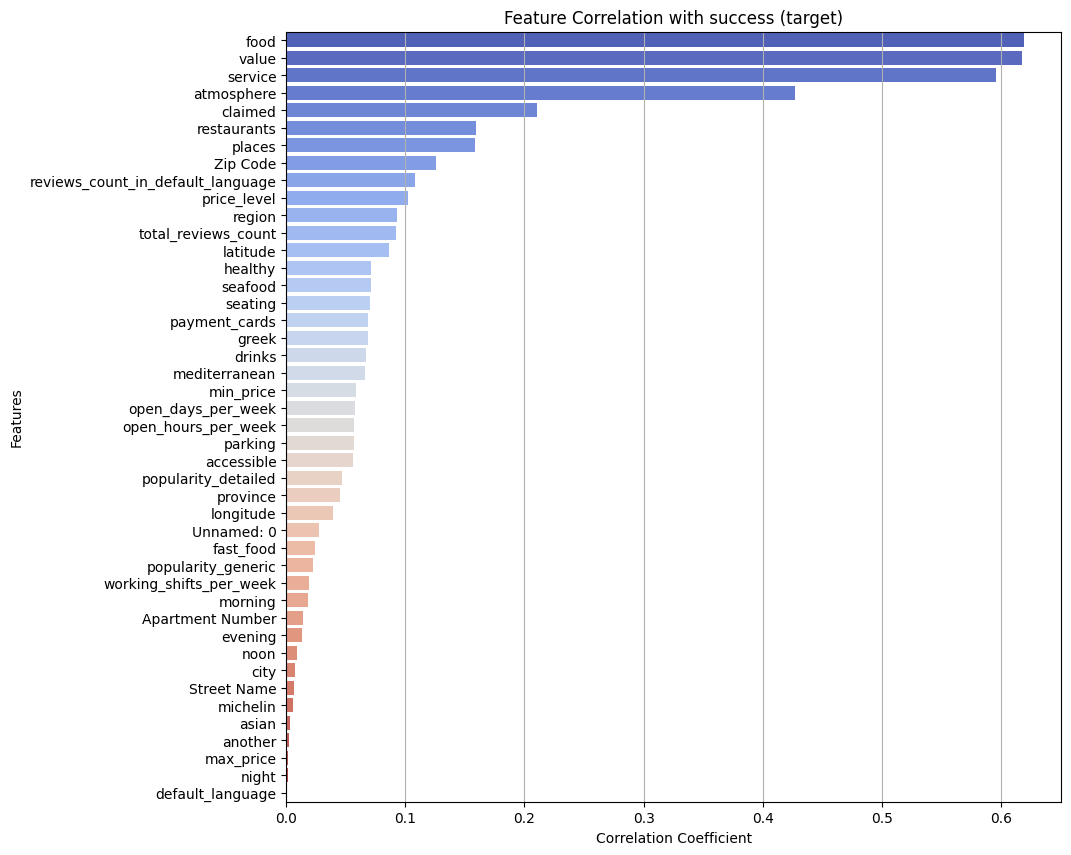

In [9]:
# Sample 10,000 random rows
#df_sampled = df3.sample(n=15_000, random_state=42)

# Define target column name (change this to your actual target column)
target_column = "success (target)"

# Compute correlation of all features with the target
correlation_with_target = df4.corr()[target_column].drop(target_column)  # Exclude self-correlation

# Sort correlations by absolute value (optional, for better visualization)
correlation_with_target = correlation_with_target.abs().sort_values(ascending=False)

# Plot the correlations
plt.figure(figsize=(10, 10))
sns.barplot(x=correlation_with_target.values, y=correlation_with_target.index, palette="coolwarm")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Features")
plt.title(f"Feature Correlation with {target_column}")
plt.grid(axis="x")

# Show the plot
plt.show()

<ipython-input-10-7b9a00e5fae6>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_with_target.values, y=correlation_with_target.index, palette="coolwarm")


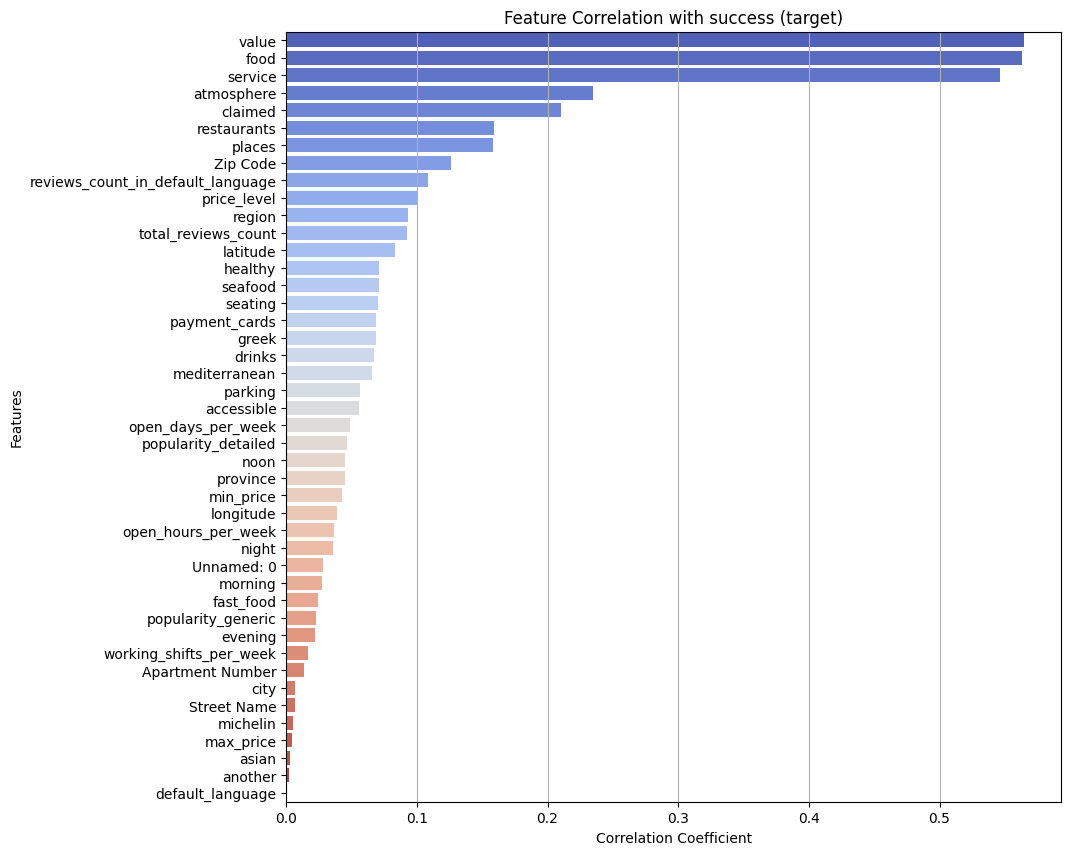

In [10]:
# Sample 10,000 random rows
#df_sampled = df3.sample(n=15_000, random_state=42)

# Define target column name (change this to your actual target column)
target_column = "success (target)"

# Compute correlation of all features with the target
correlation_with_target = df5.corr()[target_column].drop(target_column)  # Exclude self-correlation

# Sort correlations by absolute value (optional, for better visualization)
correlation_with_target = correlation_with_target.abs().sort_values(ascending=False)

# Plot the correlations
plt.figure(figsize=(10, 10))
sns.barplot(x=correlation_with_target.values, y=correlation_with_target.index, palette="coolwarm")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Features")
plt.title(f"Feature Correlation with {target_column}")
plt.grid(axis="x")

# Show the plot
plt.show()

In [11]:

# Choose either KNN or MICE:
mice_imputer = IterativeImputer(max_iter=10, random_state=42)  # KNN Imputer
# imputer = IterativeImputer()  # MICE Imputer

# Apply imputation
df6 = mice_imputer.fit_transform(df4)

df6 = pd.DataFrame(df6, columns=df4.columns)  # Convert back to DataFrame

# Now apply clipping (this will work!)
df6 = df6.clip(lower=col_min.values, upper=col_max.values, axis=1)



In [12]:
for col in round_cols:
    df6[col] = [round_to_half(i) for i in df6[col]]

for col in whole_number_cols:
    df6[col] = [round(i) for i in df6[col]]

<ipython-input-13-627ab1588990>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_with_target.values, y=correlation_with_target.index, palette="coolwarm")


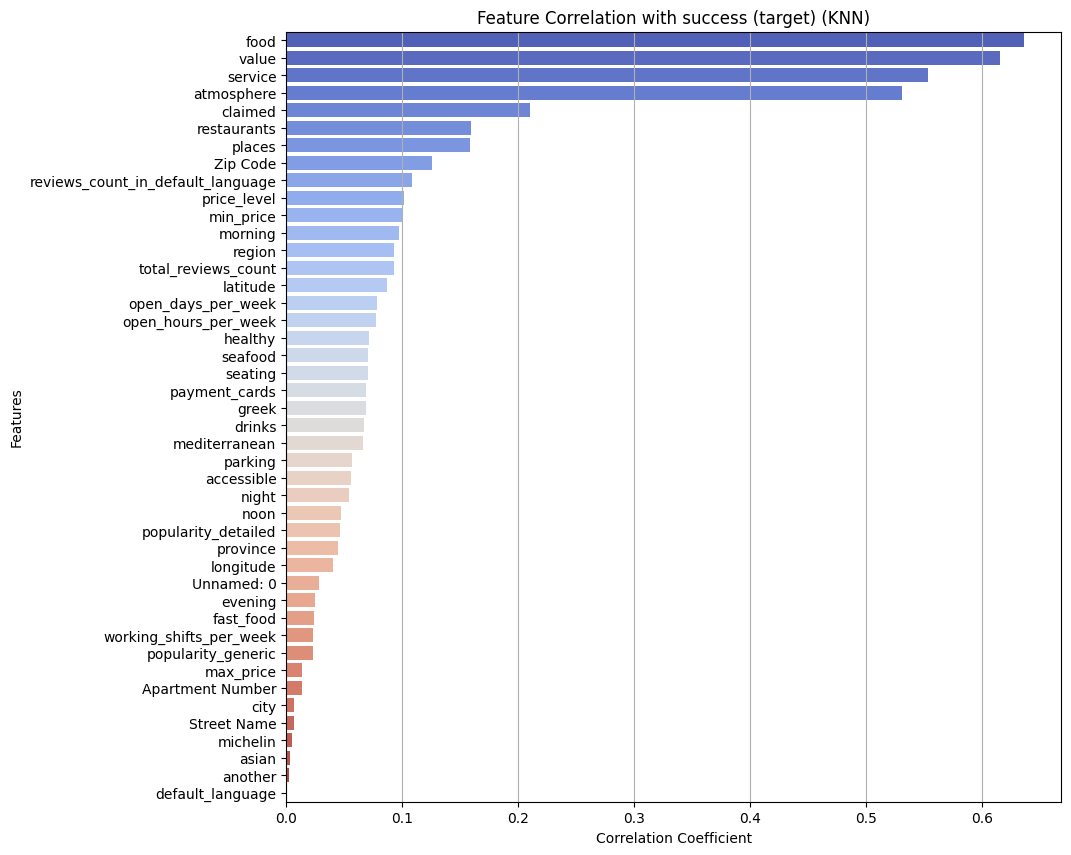

In [13]:
# Sample 10,000 random rows
#df_sampled = df3.sample(n=15_000, random_state=42)

# Define target column name (change this to your actual target column)
target_column = "success (target)"

# Compute correlation of all features with the target
correlation_with_target = df6.corr()[target_column].drop(target_column)  # Exclude self-correlation

# Sort correlations by absolute value (optional, for better visualization)
correlation_with_target = correlation_with_target.abs().sort_values(ascending=False)

# Plot the correlations
plt.figure(figsize=(10, 10))
sns.barplot(x=correlation_with_target.values, y=correlation_with_target.index, palette="coolwarm")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Features")
plt.title(f"Feature Correlation with {target_column} (KNN)")
plt.grid(axis="x")

# Show the plot
plt.show()

In [14]:
target_column = "success (target)"

# Compute correlation of all features with the target
correlation_with_target_null = df4.corr()[target_column].drop(target_column)  # Exclude self-correlation
correlation_with_target_knn = df5.corr()[target_column].drop(target_column)
correlation_with_target_mice = df6.corr()[target_column].drop(target_column)

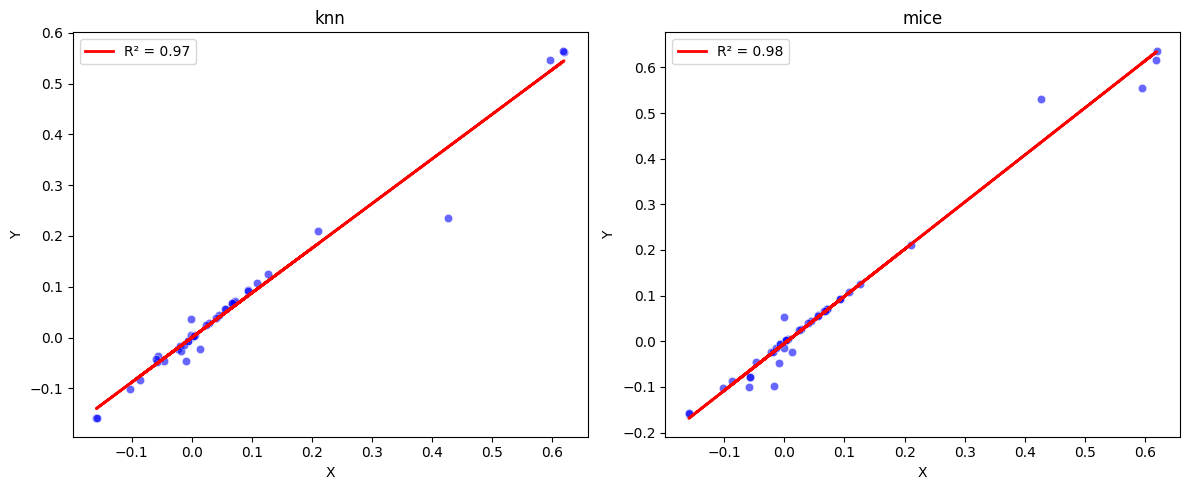

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def plot_correlation(ax, x, y, title):
    # Scatter plot
    sns.scatterplot(x=x, y=y, ax=ax, color='blue', alpha=0.6)

    # Fit linear regression
    x = np.array(x).reshape(-1, 1)
    y = np.array(y)
    model = LinearRegression()
    model.fit(x, y)
    y_pred = model.predict(x)

    # R-squared
    r2 = r2_score(y, y_pred)

    # Plot trendline
    ax.plot(x, y_pred, color='red', linewidth=2, label=f'R² = {r2:.2f}')
    ax.legend()
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

# Sample data
np.random.seed(42)
x = correlation_with_target_null
y1 = correlation_with_target_knn
y2 = correlation_with_target_mice

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_correlation(axes[0], x, y1, 'knn')
plot_correlation(axes[1], x, y2, 'mice')

plt.tight_layout()
plt.show()


In [16]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.linear_model import Ridge

In [17]:
#df6[categorial_columns] = df6[categorial_columns].astype("category")
y=df6['success (target)']
X = df6.drop(columns=['success (target)'])

# Fit models and determine if a feature is selected (1) or not (0)

lasso = Lasso(alpha=0.01).fit(X, y)
lasso_selected = (np.abs(lasso.coef_) > 0).astype(int)

# Fit Ridge model
ridge = Ridge(alpha=0.01).fit(X, y)
ridge_selected = (np.abs(ridge.coef_) > 0).astype(int)

svm = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)
svm_selected = (np.abs(svm.coef_[0]) > 0).astype(int)

gb = GradientBoostingClassifier().fit(X, y)
gb_selected = (gb.feature_importances_ > 0).astype(int)

rf = RandomForestClassifier().fit(X, y)
rf_selected = (rf.feature_importances_ > 0).astype(int)

# Create a DataFrame to store results
selection_df = pd.DataFrame({
    'Feature': X.columns,
    'Lasso': lasso_selected,
    'SVM': svm_selected,
    'GradientBoost': gb_selected,
    'RandomForest': rf_selected,
    'Ridge': ridge_selected
})

# Sum the number of selections for each feature
selection_df['Sum'] = selection_df[['Lasso', 'SVM', 'GradientBoost', 'RandomForest','Ridge']].sum(axis=1)

# Output the results
print(selection_df)

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


                              Feature  Lasso  SVM  GradientBoost  \
0                          Unnamed: 0      1    1              1   
1                              region      1    1              1   
2                            province      1    1              1   
3                                city      1    1              1   
4                            latitude      1    1              1   
5                           longitude      0    1              1   
6                             claimed      1    1              1   
7                 popularity_detailed      1    1              0   
8                  popularity_generic      0    1              1   
9                         price_level      0    1              1   
10                 open_days_per_week      0    1              1   
11                open_hours_per_week      1    1              1   
12            working_shifts_per_week      0    1              1   
13                total_reviews_count      1    

In [18]:
 #Selecting variables with a sum of selections >= 4
final_var = selection_df[selection_df['Sum'] >= 4]['Feature'].tolist()
df7 = df6[final_var].copy()
df7['success (target)'] = df6['success (target)'].copy()

# Output the result to verify
df7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21990 entries, 0 to 21989
Data columns (total 27 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         21990 non-null  int64  
 1   region                             21990 non-null  int64  
 2   province                           21990 non-null  int64  
 3   city                               21990 non-null  int64  
 4   latitude                           21990 non-null  float64
 5   longitude                          21990 non-null  float64
 6   claimed                            21990 non-null  int64  
 7   popularity_detailed                21990 non-null  int64  
 8   popularity_generic                 21990 non-null  int64  
 9   price_level                        21990 non-null  int64  
 10  open_days_per_week                 21990 non-null  int64  
 11  open_hours_per_week                21990 non-null  flo

In [19]:
import sklearn.metrics as metrics
import math
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
#!pip install xgboost
import xgboost

In [24]:
from sklearn.model_selection import train_test_split
import xgboost
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error

y = df7['success (target)']
X = df7.drop(columns=['success (target)'])

# Split into train+val and test sets (80% train+val, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Split train+val into train and val sets (75% train, 25% val from the train+val set)
#X_train, X_val, y_train, y_val = train_test_split(
#    X_train_val, y_train_val, test_size=0.25, random_state=42
#)



In [25]:

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'ADABoost': AdaBoostRegressor(random_state=42),
    'GBM': GradientBoostingRegressor(random_state=42),
    'SVM': SVR(),
    'XGBoost': xgboost.XGBRegressor(random_state=42)
}

# Store results
results = []

for name, model in models.items():
    model.fit(X_train, y_train)  # Train the model
    y_pred = model.predict(X_test)  # Make predictions

    # Compute metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)

    # RMSLE requires positive predictions
    y_pred = np.maximum(y_pred, 0)  # Ensure no negative values
    y_test = np.maximum(y_test, 0)
    rmsle = np.sqrt(mean_squared_error(np.log1p(y_test), np.log1p(y_pred)))

    # Append results
    results.append([name, mse, rmse, mae, rmsle])

# Convert to DataFrame
results_df = pd.DataFrame(results, columns=['Model', 'MSE', 'RMSE', 'MAE', 'RMSLE'])

# Display the table sorted by RMSE
results_df.sort_values(by='RMSE', ascending=True)


,Model,MSE,RMSE,MAE,RMSLE
6,XGBoost,0.077810,0.278944,0.172783,0.194569
2,Random Forest,0.080921,0.284466,0.164097,0.199586
4,GBM,0.088875,0.298120,0.181378,0.209303
3,ADABoost,0.101732,0.318955,0.197394,0.223053
0,Linear Regression,0.129840,0.360333,0.301171,0.247726
1,Decision Tree,0.158709,0.398382,0.158709,0.276138
5,SVM,0.311742,0.558339,0.401940,0.396300


In [27]:
xgb = xgboost.XGBRegressor()
print(xgb.get_params())

{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [30]:
from sklearn.model_selection import RandomizedSearchCV

xgb = xgboost.XGBRegressor(objective='reg:squarederror', random_state=42)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 3, 5, 7],
}

# Perform Randomized Search
random_search = RandomizedSearchCV(
    estimator=xgb, param_distributions=param_grid,
    scoring='neg_mean_squared_error', n_iter=20,
    cv=5, verbose=1, n_jobs=-1, random_state=42
)

# Fit to training data
random_search.fit(X_train, y_train)

# Best parameters
print("Best Hyperparameters:", random_search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Hyperparameters: {'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 3, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.8}


In [35]:
from xgboost import XGBRegressor
# Assuming df is your DataFrame and 'target' is the column to predict
X = df7.drop(columns=['success (target)'])  # Features
y = df7['success (target)']  # Target variable

# Split into Train (70%), Validation (15%), Test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print dataset shapes
print("Train Set:", X_train.shape, y_train.shape)
print("Validation Set:", X_val.shape, y_val.shape)
print("Test Set:", X_test.shape, y_test.shape)

Train Set: (15393, 26) (15393,)
Validation Set: (3298, 26) (3298,)
Test Set: (3299, 26) (3299,)


In [37]:
# Initialize XGBRegressor with best hyperparameters
xgb_model = XGBRegressor(
    subsample=0.8,
    n_estimators=1000,
    min_child_weight=3,
    max_depth=10,
    learning_rate=0.05,
    gamma=0.3,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)

# Train the model on the training set
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)

[0]	validation_0-rmse:0.47823
[1]	validation_0-rmse:0.46588
[2]	validation_0-rmse:0.45246
[3]	validation_0-rmse:0.44014
[4]	validation_0-rmse:0.42777
[5]	validation_0-rmse:0.41722
[6]	validation_0-rmse:0.40673
[7]	validation_0-rmse:0.39778
[8]	validation_0-rmse:0.38863
[9]	validation_0-rmse:0.38056
[10]	validation_0-rmse:0.37252
[11]	validation_0-rmse:0.36504
[12]	validation_0-rmse:0.35805
[13]	validation_0-rmse:0.35206
[14]	validation_0-rmse:0.34634
[15]	validation_0-rmse:0.34123
[16]	validation_0-rmse:0.33607
[17]	validation_0-rmse:0.33113
[18]	validation_0-rmse:0.32728
[19]	validation_0-rmse:0.32341
[20]	validation_0-rmse:0.31972
[21]	validation_0-rmse:0.31647
[22]	validation_0-rmse:0.31329
[23]	validation_0-rmse:0.31071
[24]	validation_0-rmse:0.30832
[25]	validation_0-rmse:0.30601
[26]	validation_0-rmse:0.30391
[27]	validation_0-rmse:0.30214
[28]	validation_0-rmse:0.30044
[29]	validation_0-rmse:0.29862
[30]	validation_0-rmse:0.29746
[31]	validation_0-rmse:0.29620
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.3, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)